In [1]:
# Code derived from tensorflow/tensorflow/models/image/imagenet/classify_image.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import os.path
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf
import glob
import scipy.misc
import math
import sys

MODEL_DIR = '/tmp/imagenet'
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
softmax = None

In [2]:
# Call this function with list of images. Each of elements should be a 
# numpy array with values ranging from 0 to 255.
def get_inception_score(images, splits=10):
  assert(type(images) == list)
  assert(type(images[0]) == np.ndarray)
  assert(len(images[0].shape) == 3)
  assert(np.max(images[0]) > 10)
  assert(np.min(images[0]) >= 0.0)
  inps = []
  for img in images:
    img = img.astype(np.float32)
    inps.append(np.expand_dims(img, 0))
  bs = 100
  with tf.Session() as sess:
    preds = []
    n_batches = int(math.ceil(float(len(inps)) / float(bs)))
    for i in range(n_batches):
        sys.stdout.write(".")
        sys.stdout.flush()
        inp = inps[(i * bs):min((i + 1) * bs, len(inps))]
        inp = np.concatenate(inp, 0)
        pred = sess.run(softmax, {'ExpandDims:0': inp})
        preds.append(pred)
    preds = np.concatenate(preds, 0)
    scores = []
    for i in range(splits):
      part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
      kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
      kl = np.mean(np.sum(kl, 1))
      scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores), preds

# This function is called automatically.
def _init_inception():
  global softmax
  if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(MODEL_DIR, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(MODEL_DIR)
  with tf.gfile.FastGFile(os.path.join(
      MODEL_DIR, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
  # Works with an arbitrary minibatch size.
  with tf.Session() as sess:
    pool3 = sess.graph.get_tensor_by_name('pool_3:0')
    ops = pool3.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            shape = [s.value for s in shape]
            new_shape = []
            for j, s in enumerate(shape):
                if s == 1 and j == 0:
                    new_shape.append(None)
                else:
                    new_shape.append(s)
            o._shape = tf.TensorShape(new_shape)
    w = sess.graph.get_operation_by_name("softmax/logits/MatMul").inputs[1]
    logits = tf.matmul(tf.squeeze(pool3), w)
    softmax = tf.nn.softmax(logits)

if softmax is None:
  _init_inception()

In [3]:
!ls /tmp/imagenet/

classify_image_graph_def.pb
cropped_panda.jpg
imagenet_2012_challenge_label_map_proto.pbtxt
imagenet_synset_to_human_label_map.txt
inception-2015-12-05.tgz
LICENSE


# ALI

In [4]:
import glob
from PIL import Image
samples = glob.glob('/home/dulyanov/projects/icml2017/d/ALI/samples/*.png')

imgs = []
for s in samples[:50000]:
    imgs.append(np.array(Image.open(s)))

In [20]:
ali_inception = get_inception_score(imgs)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [21]:
ali_inception[0], ali_inception[1]

(2.3258932, 0.017689418)

# ALI 10 ep

In [5]:
import glob
from PIL import Image
samples = glob.glob('/home/dulyanov/projects/icml2017/d/ALI/samples_10ep/*.png')

imgs = []
for s in samples[:50000]:
    imgs.append(np.array(Image.open(s)))

In [6]:
ali_inception = get_inception_score(imgs)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [7]:
ali_inception[0], ali_inception[1]

(2.4796615, 0.0180098)

# REAL

In [23]:
import glob
from PIL import Image
samples = glob.glob('/sdh/data/celebA/imgs1/train/*.jpg')

imgs = []

class ALICropAndScale(object):
    def __call__(self, img):
        return img.resize((64, 78), Image.ANTIALIAS).crop((0, 7, 64, 64 + 7))

pre = ALICropAndScale()
for s in samples[:50000]:
    imgs.append(np.array(pre(Image.open(s))))

In [24]:
real_inception = get_inception_score(imgs)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [25]:
real_inception

(3.3169017,
 0.028190788,
 array([[  1.83248500e-04,   5.99587947e-05,   2.99554922e-05, ...,
           1.83250333e-04,   1.83240205e-04,   1.83240118e-04],
        [  1.17593794e-04,   6.82790051e-05,   4.18332784e-05, ...,
           1.17594514e-04,   1.17589807e-04,   1.17589749e-04],
        [  1.58362978e-04,   4.45855912e-05,   3.56577257e-05, ...,
           1.58364783e-04,   1.58355790e-04,   1.58355790e-04],
        ..., 
        [  3.30264389e-04,   2.31555707e-04,   2.92453769e-04, ...,
           3.30267212e-04,   3.30249895e-04,   3.30249895e-04],
        [  1.48959531e-04,   6.89262233e-05,   5.91003663e-05, ...,
           1.48960666e-04,   1.48953768e-04,   1.48953710e-04],
        [  2.08704892e-04,   9.46095388e-05,   2.77590269e-04, ...,
           2.08706784e-04,   2.08696831e-04,   2.08696831e-04]], dtype=float32))

# AGE

In [26]:
import glob
from PIL import Image
samples = glob.glob('samples/*.png')

imgs = []

# class ALICropAndScale(object):
#     def __call__(self, img):
#         return img.resize((64, 78), Image.ANTIALIAS).crop((0, 7, 64, 64 + 7))


for s in samples[:50000]:
    imgs.append(np.array((Image.open(s))))

In [27]:
len(imgs)

50000

In [28]:
age_inception = get_inception_score(imgs)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [29]:
age_inception

(2.5666127,
 0.018862788,
 array([[  6.68427165e-05,   1.64554640e-05,   3.60307531e-05, ...,
           6.68432913e-05,   6.68400316e-05,   6.68400316e-05],
        [  1.26621177e-04,   4.26935439e-05,   3.36468038e-05, ...,
           1.26622370e-04,   1.26616273e-04,   1.26616273e-04],
        [  2.68421922e-04,   1.92357256e-04,   3.88537504e-04, ...,
           2.68425094e-04,   2.68412434e-04,   2.68412317e-04],
        ..., 
        [  1.60222349e-04,   1.25755992e-04,   1.55814996e-04, ...,
           1.60223266e-04,   1.60216310e-04,   1.60216223e-04],
        [  1.09401582e-04,   7.34977293e-05,   8.57213017e-05, ...,
           1.09402325e-04,   1.09397108e-04,   1.09397108e-04],
        [  1.31820314e-04,   1.04096958e-04,   1.69734587e-04, ...,
           1.31821769e-04,   1.31814726e-04,   1.31814668e-04]], dtype=float32))

In [89]:
import glob
import skimage.exposure
from PIL import Image
samples = glob.glob('samples_imagenet/*.png')

imgs = []

# class ALICropAndScale(object):
#     def __call__(self, img):
#         return img.resize((64, 78), Image.ANTIALIAS).crop((0, 7, 64, 64 + 7))


for s in samples[:10000]:
    im = np.array((Image.open(s)))#*1.1
#     d = skimage.exposure.rescale_intensity(im)*255
    d = im
    imgs.append(d)

In [90]:
age_inception_cifar10 = get_inception_score(imgs[:10000])

....................................................................................................

In [91]:
age_inception_cifar10

(6.6626258,
 0.15952884,
 array([[  8.42314985e-05,   1.45280138e-02,   4.05741681e-04, ...,
           8.42318550e-05,   8.42277950e-05,   8.42277586e-05],
        [  1.14522823e-04,   1.12495130e-04,   1.72145119e-05, ...,
           1.14523471e-04,   1.14517250e-04,   1.14517250e-04],
        [  3.05148278e-04,   2.58138659e-03,   1.04887877e-03, ...,
           3.05149995e-04,   3.05132096e-04,   3.05131980e-04],
        ..., 
        [  9.75605435e-05,   7.73396529e-03,   2.04051888e-04, ...,
           9.75610092e-05,   9.75557923e-05,   9.75557923e-05],
        [  3.53461837e-05,   2.31624072e-05,   4.11309484e-05, ...,
           3.53463874e-05,   3.53447358e-05,   3.53447358e-05],
        [  3.07415525e-04,   2.21061334e-03,   5.02747134e-04, ...,
           3.07418144e-04,   3.07399372e-04,   3.07399227e-04]], dtype=float32))

In [88]:
age_inception_cifar10

(6.7536201,
 0.16781445,
 array([[  7.49496103e-05,   1.15129352e-02,   3.33329604e-04, ...,
           7.49499668e-05,   7.49462488e-05,   7.49462488e-05],
        [  1.06880638e-04,   9.43865380e-05,   1.97853024e-05, ...,
           1.06881249e-04,   1.06875530e-04,   1.06875530e-04],
        [  2.73700804e-04,   2.05168175e-03,   9.36503522e-04, ...,
           2.73702521e-04,   2.73686310e-04,   2.73686164e-04],
        ..., 
        [  1.18725911e-04,   6.81953039e-03,   2.20326066e-04, ...,
           1.18726479e-04,   1.18720149e-04,   1.18720025e-04],
        [  2.79572905e-05,   1.72646069e-05,   3.11700569e-05, ...,
           2.79574233e-05,   2.79561154e-05,   2.79561154e-05],
        [  3.12909106e-04,   2.85409321e-03,   6.62158825e-04, ...,
           3.12912045e-04,   3.12893273e-04,   3.12893098e-04]], dtype=float32))

In [ ]:
5.7993445 10k

In [32]:
age_inception_cifar10

(5.9036341,
 0.044176444,
 array([[  1.19255128e-04,   9.87377425e-05,   2.67422893e-05, ...,
           1.19256154e-04,   1.19249213e-04,   1.19249213e-04],
        [  3.44684493e-04,   3.80504457e-03,   1.22624857e-03, ...,
           3.44687607e-04,   3.44668195e-04,   3.44668195e-04],
        [  2.66861171e-04,   4.99223871e-03,   4.29401371e-05, ...,
           2.66862829e-04,   2.66848801e-04,   2.66848685e-04],
        ..., 
        [  2.62634334e-04,   7.35559035e-04,   1.24968428e-04, ...,
           2.62636837e-04,   2.62620539e-04,   2.62620422e-04],
        [  2.37925342e-04,   7.72738495e-05,   2.67875934e-04, ...,
           2.37927394e-04,   2.37913919e-04,   2.37913788e-04],
        [  2.35163665e-04,   3.29306611e-04,   3.39004537e-03, ...,
           2.35165920e-04,   2.35152693e-04,   2.35152562e-04]], dtype=float32))

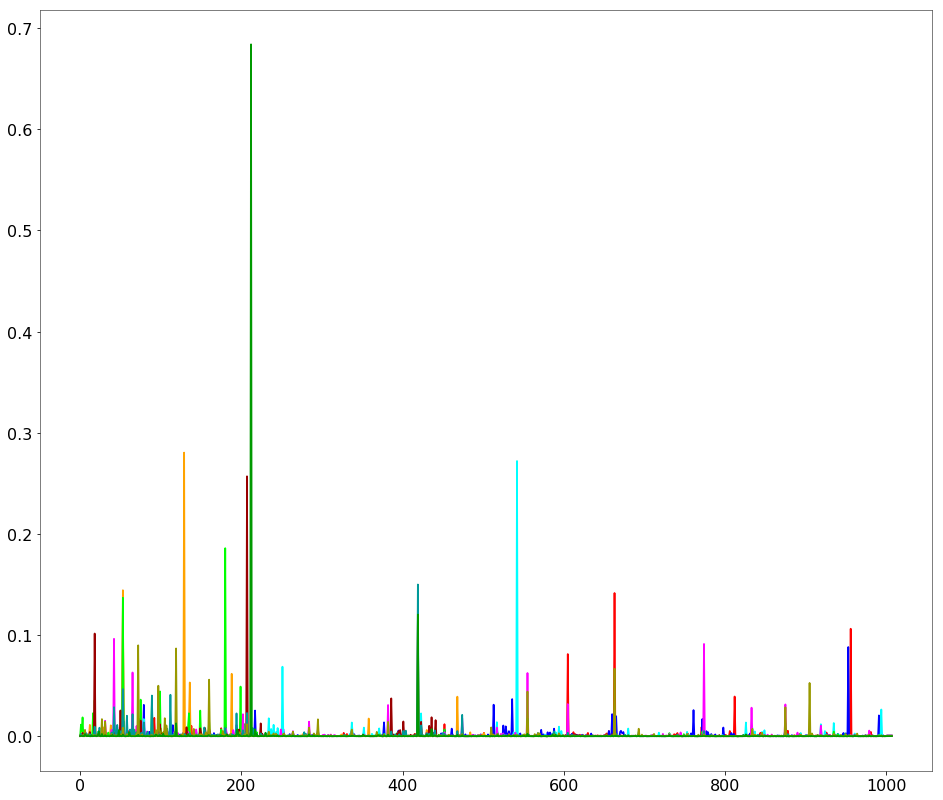

In [52]:
_ = plt.plot(age_inception_cifar10[2][:10].T)

In [34]:
__imp

/home/dulyanov/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dulyanov/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [249]:
# if DATASET=='cifar10':
#     # default params work for cifar
#     pass
# elif DATASET=='celeba':
#     opt.update({      
#              'nz':64, 
#              'dataset': 'celeba',
#              'dataroot': '/sdh/data/celebA/imgs1', # put here your path
#              'image_size':64, 
#             })

# opt['nc'] =  3

torch.cuda.set_device(0)

DATASET = 'colorization'
dtype = torch.FloatTensor
opt=({      
         'nz':16, 
         'nout':16,
         'dataroot': '/sdh/data/stanford_cars/cropped_scaled_lab_dataset',
#          'dataroot': '/sdh/data/stanford_cars/cropped_scaled_dataset',
         'ngf':64, 
         'ndf': 64, 
         'noise': 'sphere',
         'ngpu': 1,
         'dataset': 'colorization',
         'image_size':64,
         'workers':1,
         'batch_size': 64,
         'nc':3
        })

opt= convert(opt)

# Load g,e
# E_path = 'data/checkpoints1/color_cars1/netE_epoch_64.pth'
# G_path = 'data/checkpoints1/color_cars1/netG_epoch_64.pth'

E_path = 'data/checkpoints/color_cars3_2_/netE_epoch_129.pth'
G_path = 'data/checkpoints/color_cars3_2_/netG_epoch_129.pth'

E_path = 'data/checkpoints/color_cars_ae/netD_epoch_19.pth'
G_path = 'data/checkpoints/color_cars_ae/netG_epoch_19.pth'

netG = torch.load(G_path).type(dtype)
netE = torch.load(E_path).type(dtype)
    
netG.eval()
netE.eval()

_netE_Base (
  (main): Sequential (
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU (0.2, inplace)
    (11): Conv2d(512, 16, kernel_size=(4, 4), stride=(1, 1))
  )
)

# Sample

In [250]:
def deprocess(tensor):
    if 'colorization' in opt.dataset:
        out = torch.FloatTensor(*tensor.size())

        for i in range(tensor.size(0)):
            this = tensor[i].transpose(0, 2).contiguous().numpy()

            color.colorconv.lab_ref_white = np.array([0.96422, 1.0, 0.82521])

            out[i] = torch.FloatTensor(
                color.lab2rgb(this.astype(np.float64))).transpose(0, 2).contiguous()
        return out
    else:
        return tensor / 2 + 0.5

def conditional(x):
    return x[:, :1, :, :].clone()

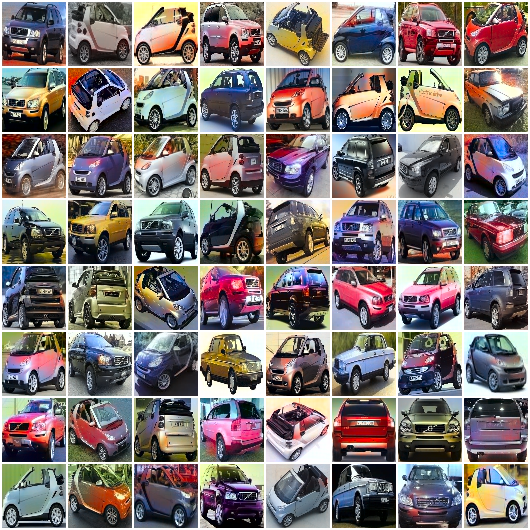

In [251]:
dataloader = setup_dataset(opt, train=False)
d = dataloader.next()
x = Variable(d[0], volatile=True)

z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
z = normalize(z)

samples = netG(conditional(x), z).data.cpu()


grid = torchvision.utils.make_grid(deprocess(samples), pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

In [252]:
# grid = torchvision.utils.make_grid(d[1], pad_value=1)
# grid_PIL = transforms.ToPILImage()(grid)
# grid_PIL

# Reconstruct

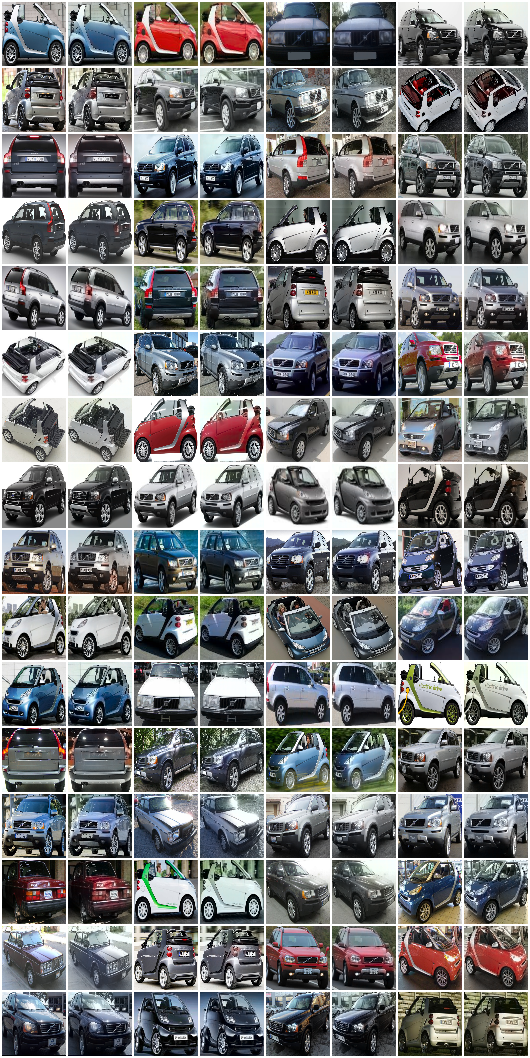

In [253]:
dataloader = setup_dataset(opt, train=False)
d = dataloader.next()

x = Variable(d[0], volatile=True)

ex = netE(x)
gex = netG(conditional(x), ex)


t = torch.FloatTensor(x.size(0) * 2, x.size(1), x.size(2), x.size(3))
t[0::2] = x.data.cpu()[:]
t[1::2] = gex.data.cpu()[:]


grid = torchvision.utils.make_grid(deprocess(t), pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

# Color transfer

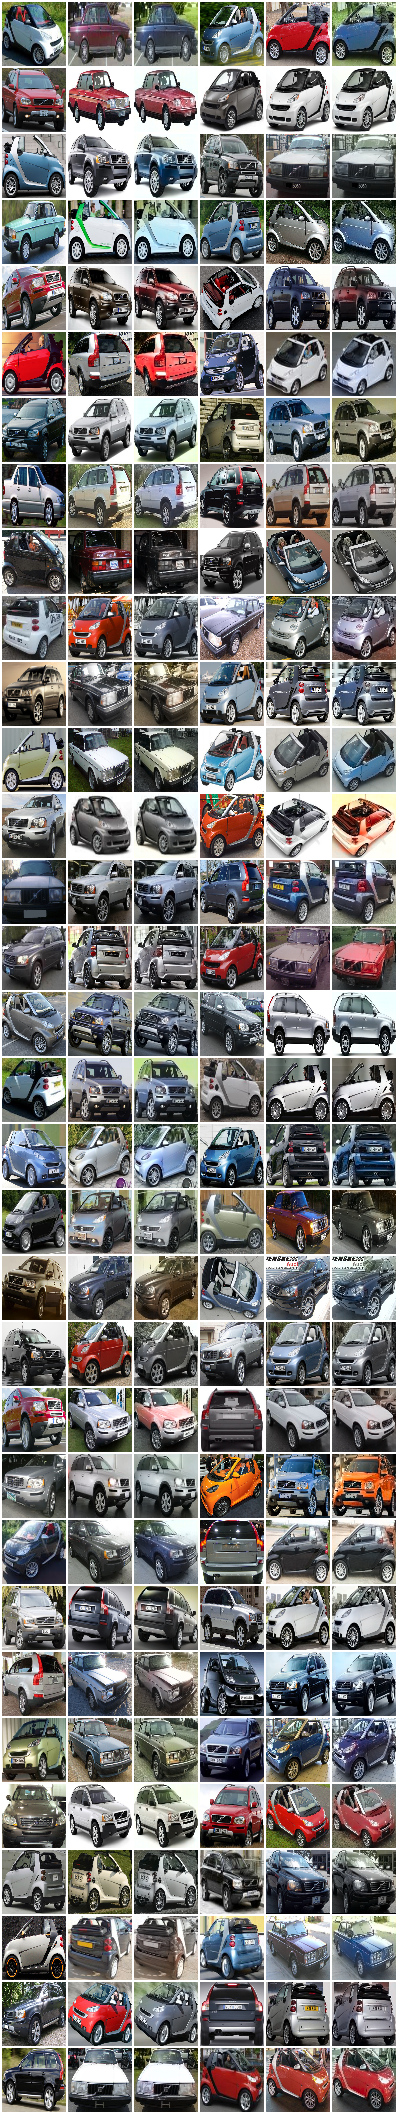

In [254]:
dataloader = setup_dataset(opt, train=False)
d1 = dataloader.next()
x1 = Variable(d1[0], volatile=True)

d2 = dataloader.next()
x2 = Variable(d2[0], volatile=True)

ex1 = netE(x1)
gex = netG(conditional(x2), ex1)


t = torch.FloatTensor(x.size(0) * 3, x.size(1), x.size(2), x.size(3))
t[0::3] = x1.data.cpu()[:]
t[1::3] = x2.data.cpu()[:]
t[2::3] = gex.data.cpu()[:]


grid = torchvision.utils.make_grid(deprocess(t), pad_value=1,nrow=6)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

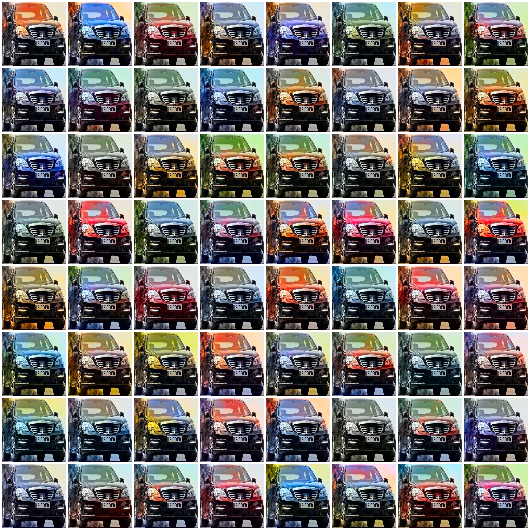

In [260]:
dataloader = setup_dataset(opt, train=True)
d = dataloader.next()
for i in range(1,d[0].size(0)):
    d[0][i] = d[0][0]
x = Variable(d[0], volatile=True)

z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
z = normalize(z)

samples = netG(conditional(x), z).data.cpu()


grid = torchvision.utils.make_grid(deprocess(samples), pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

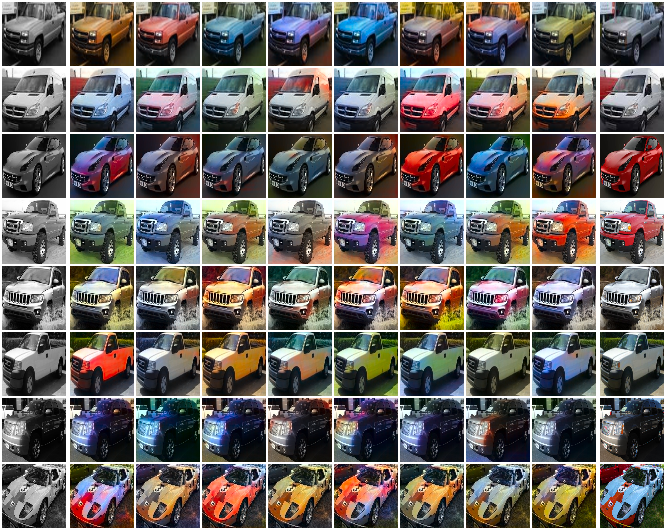

In [259]:
dataloader = setup_dataset(opt, train=True)
d = dataloader.next()
for j in range(0,63,8):
    for i in range(8):
        d[0][j+i] = d[0][j]
        d[1][j+i] = d[1][j]
x = Variable(d[0], volatile=True)

z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
z = normalize(z)

c = conditional(x)
samples = netG(c, z).data.cpu()


grid = torchvision.utils.make_grid(deprocess(samples), pad_value=1)


gray = torchvision.utils.make_grid(c.data.cpu()[::8]/100, pad_value=1, nrow=1)
gt = torchvision.utils.make_grid(d[1][::8], pad_value=1, nrow=1)

grid = torch.cat([gray, grid, gt], dim=2)

grid_PIL = transforms.ToPILImage()(grid)

grid_PIL